In [2]:
# Load the latest summary data

import pandas as pd

url = 'https://raw.githubusercontent.com/ratreya/jupyter-notebooks/master/covid-merged-daily-reports.csv'
df = pd.read_csv(url)
days = sorted(df['Date'].unique())

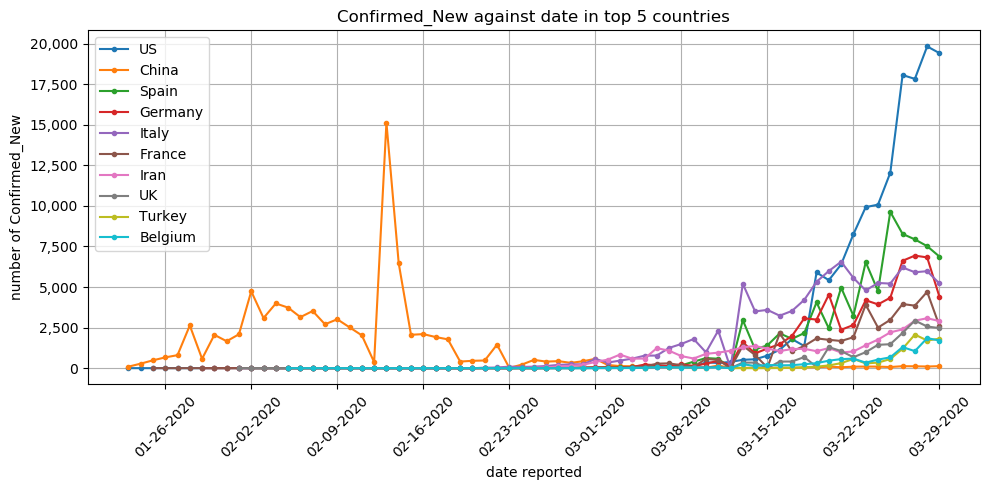

In [3]:
# Plot cumulative growth vs. time in top 5 countries

from pylab import *
from math import ceil

# This is the variable to consider - options are 'Confirmed', 'Deaths', 'Recovered', 'Confirmed_New', 'Deaths_New', 'Recovered_New'
variable = 'Confirmed_New'

# Aggregate at country level
country_level = df.groupby(['Country', 'Date'], as_index=False).sum()

# Need to recalculate deltas because first day that with County data will aggregatet to zero otherwise
for country in country_level['Country'].unique():
    confirmed = country_level[country_level['Country'] == country]['Confirmed'].values.tolist()
    confirmed_deltas = [np.nan] + [confirmed[i] - confirmed[i-1] for i in range(1, len(confirmed))]
    country_level.loc[country_level['Country'] == country, 'Confirmed_New'] = confirmed_deltas
    deaths = country_level[country_level['Country'] == country]['Deaths'].values.tolist()
    deaths_deltas = [np.nan] + [deaths[i] - deaths[i-1] for i in range(1, len(deaths))]
    country_level.loc[country_level['Country'] == country, 'Deaths_New'] = deaths_deltas
    recovered = country_level[country_level['Country'] == country]['Recovered'].values.tolist()
    recovered_deltas = [np.nan] + [recovered[i] - recovered[i-1] for i in range(1, len(recovered))]
    country_level.loc[country_level['Country'] == country, 'Recovered_New'] = recovered_deltas

# Countries to compare - top 5 by variable
top_countries = sorted([(x, country_level[country_level['Country'] == x][variable].max()) for x in country_level['Country'].unique()], reverse=True, key=lambda y: 0 if np.isnan(y[1]) else y[1])[:10]
top_countries = [x[0] for x in top_countries]

# Align the various series by date
data = pd.DataFrame(columns=['Date', variable])
for country in top_countries:
    data = data.merge(country_level[country_level['Country'] == country][['Date', variable]], how='outer', on='Date', suffixes=('', '_' + country), sort=True)

fig, axes = plt.subplots(figsize=(10,5), dpi=100)
for country in top_countries:
    axes.plot(data[variable + '_' + country], label=country, marker='.')

x = data['Date'].values.tolist()
axes.legend(loc=2)
axes.set_xlabel('date reported')
axes.set_ylabel('number of %s' % variable)
axes.set_title('%s against date in top 5 countries' % variable);
idx = list(reversed(range(len(x)-1, -1, -int(ceil((len(x)+1)/10))))) # make sure the latest label is always shown
axes.set_yticklabels(['{:,}'.format(int(x)) for x in axes.get_yticks().tolist()])
plt.xticks(ticks=idx, labels=[x[i] for i in idx])
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

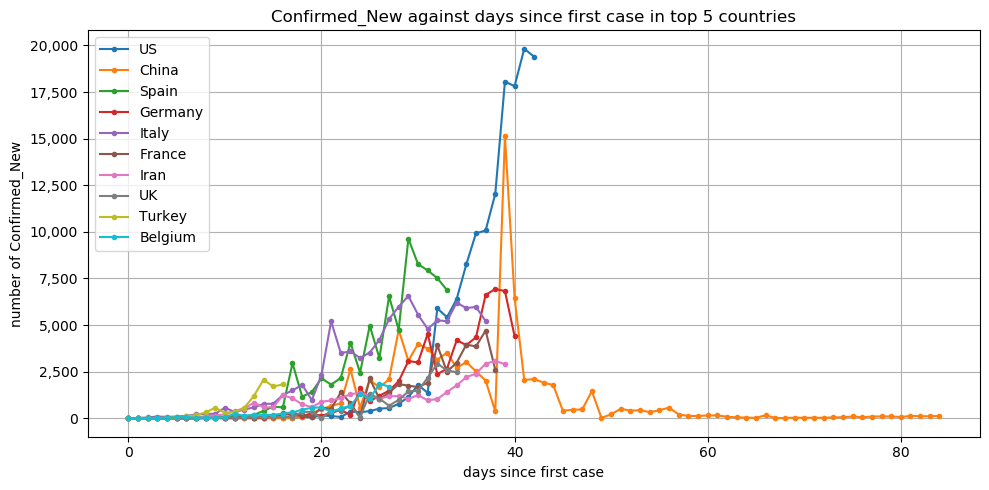

In [5]:
# Plot cumulative growth vs. time since first case in top 5 countries

from pylab import *

def align(data):
    # Find the index with the lowest non-zero starting case number
    base = min(((idx, val) for (idx, val) in enumerate(data) if val[0] > 0), key = lambda x: x[1][0])[0]

    # Align everyone else to this base
    for i in [x for x in range(len(data)) if x != base]:
        padding = min(((x[0], abs(x[1] - data[i][0])) for x in enumerate(data[base])), key = lambda x: x[1])[0]
        data[i] = [0 for i in range(padding)] + data[i]
    return data

# Countries to compare
data = align([[x for x in country_level[country_level['Country'] == top_countries[i]][variable].values.tolist() if x > 0] for i in range(len(top_countries))])

fig, axes = plt.subplots(figsize=(10,5), dpi=100)

for i in range(len(data)):
    axes.plot(data[i], label = top_countries[i], marker='.')

axes.legend(loc=2)
axes.set_xlabel('days since first case')
axes.set_ylabel('number of %s' % variable)
axes.set_title('%s against days since first case in top 5 countries' % variable);
axes.set_yticklabels(['{:,}'.format(int(x)) for x in axes.get_yticks().tolist()])
plt.grid()
plt.tight_layout()
plt.show()
#fig.savefig("covid-by-country.png", dpi=200)

In [85]:
# Plot top contributors to global trend

import altair as alt

alt.renderers.enable('default')

sans = country_level[['Country', 'Date', variable]]
# Drop 03-12-2020 as there seems to be a reporting problem on the previous day
sans = sans.drop(sans[sans['Date'] == '03-12-2020'].index)
# Drop 02-12-2020 as there seems to be a reporting problem on the previous day
sans = sans.drop(sans[sans['Date'] == '02-12-2020'].index)

# Align the various series by date
data = pd.DataFrame(columns=['Date', variable])
legend = top_countries[:-2]
for country in legend:
    data = data.merge(sans[sans['Country'] == country][['Date', variable]], how='outer', on='Date', suffixes=('', '_' + country), sort=True)

# Add all others and introduce it into the dataframe
other_countries = set(sans['Country'].unique()) - set(legend)
others = sans[sans['Country'].isin(other_countries)].groupby('Date', as_index=False).sum()
data = data.merge(others, how='outer', on='Date', suffixes=('', '_Others'))
legend += ['Others']

# Rename the columns to be country names
data.rename({variable + '_' + x : x for x in legend}, inplace=True, axis=1)
data = data.melt(id_vars='Date', value_vars=legend, var_name='Country', value_name='Value')

chart = alt.Chart(data).mark_area().encode(
    alt.X('Date:T', axis=alt.Axis(domain=False, format='%d %b', tickSize=0)),
    alt.Y('Value:Q', stack='center', axis=None),
    alt.Color('Country:N')
).properties(width=1000, height=600)

chart.display()

alt.Chart(...)

In [111]:
# Plot top contributing states to US trend

import altair as alt

us_state_level = df[df['Country'] == 'US'].groupby(['State', 'Date'], as_index=False).sum()
# Drop 03-22-2020 as there seems to be a reporting problem on the previous day
us_state_level = us_state_level.drop(us_state_level[us_state_level['Date'] == '03-22-2020'].index)
us_state_level = us_state_level[us_state_level['Date'] >= '03-01-2020']

# Align the various series by date
data = pd.DataFrame(columns=['Date', variable])
legend = us_state_level[us_state_level['Date'] == days[-1]].sort_values('Confirmed', ascending=False)['State'].values.tolist()[:10]
for state in legend:
    data = data.merge(us_state_level[us_state_level['State'] == state][['Date', variable]], how='outer', on='Date', suffixes=('', '_' + state), sort=True)

# Add all others and introduce it into the dataframe
other_states = set(us_state_level['State'].unique()) - set(legend)
others = us_state_level[us_state_level['State'].isin(other_states)].groupby('Date', as_index=False).sum()
data = data.merge(others, how='outer', on='Date', suffixes=('', '_Others'))
legend += ['Others']

# Rename the columns to be state names
data.rename({variable + '_' + x : x for x in legend}, inplace=True, axis=1)
data = data.melt(id_vars='Date', value_vars=legend, var_name='State', value_name='Value')

chart = alt.Chart(data).mark_area().encode(
    alt.X('Date:T', axis=alt.Axis(domain=False, format='%d %b', tickSize=0)),
    alt.Y('Value:Q', stack='center', axis=None),
    alt.Color('State:N')
).properties(width=1000, height=600)

chart.display()

alt.Chart(...)